In [12]:
%load_ext autoreload
%autoreload 2

import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
from IPython.display import clear_output
import time

from conditional_density_estimators import ConditionalDIFDensityEstimator
from posterior_sampler import WLBSampler
from utils import plot_2d_function, plot_likelihood_function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from targets.conditional_density_estimation_target import DoubleWave
target = DoubleWave()

N_simulations = 2000
D_theta = target.sample_prior(N_simulations)
D_x = target.simulate(D_theta)

mu_theta = torch.zeros(1)
sigma_theta = torch.eye(1)
theta_prior_distribution = torch.distributions.MultivariateNormal(mu_theta, sigma_theta)
theta0 = theta_prior_distribution.sample()

N_observations = 1000
x0 = target.simulate(theta0.unsqueeze(0).repeat(N_observations,1))

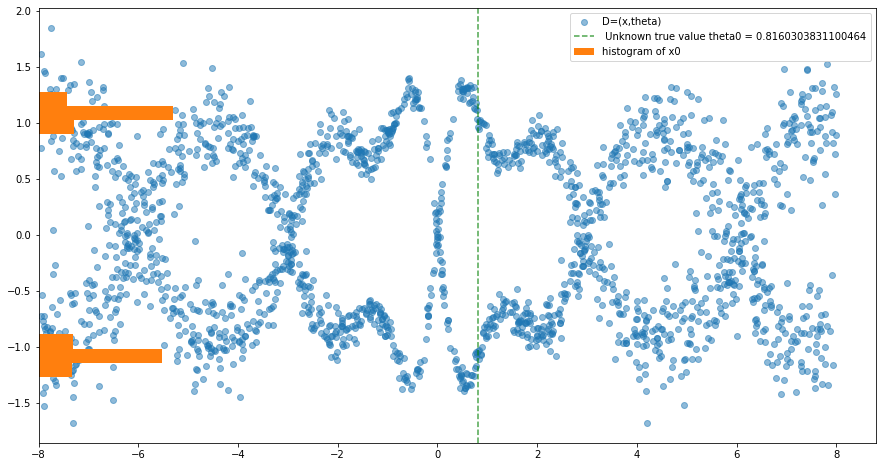

In [14]:
plt.figure(figsize = (15,8))
plt.set_xlim = (-8,8)
plt.scatter(D_theta[:,0].numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
plt.axvline(theta0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown true value theta0 = ' + str(theta0.item()))
hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -8, label = 'histogram of x0', color = 'C1')
plt.legend()

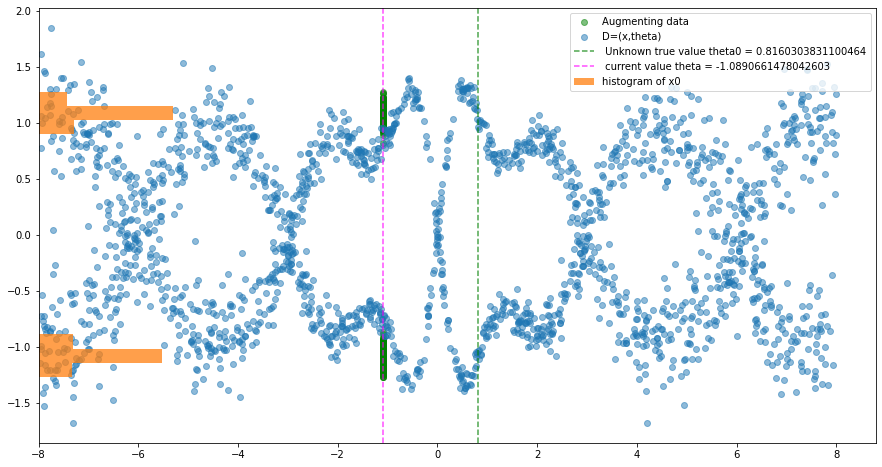

 28%|████████████████████████████████▊                                                                                    | 28/100 [00:02<00:06, 11.52it/s, loss = 1.282516 ; device: cpu]


KeyboardInterrupt: 

In [16]:
conditional_dif = ConditionalDIFDensityEstimator(D_x, D_theta, K = 10, hidden_dimensions=[32,32])
conditional_dif.train(100, bootstrap = True, lr = 5e-4)
plot_likelihood_function(conditional_dif.log_density, x_min = torch.min(D_theta), x_max = torch.max(D_theta), y_min= torch.min(D_x), y_max = torch.max(D_x),delta_x = 500, levels = 20)
plt.show()
while True:
    #sample theta
    sampler = WLBSampler(conditional_dif.log_density,1,x0)
    theta_current = sampler.sample(1, epochs = 100, lr = 5e-4).detach()
    clear_output(wait = True)
    
    #concatenate dataset
    theta_plus = theta_current.repeat(x0.shape[0],1)
    plt.figure(figsize = (15,8))
    plt.set_xlim = (-8,8)
    plt.scatter(theta_plus.detach().numpy(), x0.numpy(), label = "Augmenting data", color = 'green', alpha = .5)
    plt.scatter(D_theta[:,0].numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
    plt.axvline(theta0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown true value theta0 = ' + str(theta0.item()))
    plt.axvline(theta_current.detach().numpy(), color = 'magenta', alpha = .7, linestyle = '--', label=' current value theta = ' + str(theta_current.item()))
    hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -8, label = 'histogram of x0', color = 'C1', alpha = .75)
    plt.legend()
    plt.show()

    #sample phi|D+    
    D_theta_plus = torch.cat([D_theta, theta_plus], dim = 0)
    D_x_plus = torch.cat([D_x, x0], dim = 0)
    conditional_dif = ConditionalDIFDensityEstimator(D_x_plus, D_theta_plus, K = 2, hidden_dimensions=[32,32,32])
    conditional_dif.train(100, bootstrap = True, lr = 5e-4)
    plot_likelihood_function(conditional_dif.log_density, x_min = torch.min(D_theta), x_max = torch.max(D_theta), y_min= torch.min(D_x), y_max = torch.max(D_x),delta_x = 500, levels = 20)
    plt.show()